In [29]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [30]:
# import libraries
import cv2
import sys
import os
import time
import gc
import numpy as np
import numpy.matlib
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn as sk
import sklearn.decomposition
import skimage.draw
import tensortools as tt
import pywt
import scaleogram as scg
import scipy
import scipy.signal

import tensorly as tl
import tensorly.decomposition
import tensorly.random
import torch
import torch.cuda

import mtaper_specgram
import test_function

import math

In [31]:
# find version of openCV
# script currently works with v4.4.0
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print(f'OpenCV version: {major_ver}.{minor_ver}.{subminor_ver}')

OpenCV version: 4.4.0


In [32]:
print(cv2.getBuildInformation())


General configuration for OpenCV 4.4.0 =====================================
  Version control:               4.4.0-dirty

  Platform:
    Timestamp:                   2020-11-03T00:52:03Z
    Host:                        Linux 4.15.0-1077-gcp x86_64
    CMake:                       3.18.2
    CMake generator:             Unix Makefiles
    CMake build tool:            /bin/gmake
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (15 files):         + SSSE3 SSE4_1
      SSE4_2 (1 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (0 files):            + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 AVX
      AVX (4 files):             + SSSE3 SSE4_1 POPCNT SSE4_2 AVX
      AVX2 (29 files):           + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 FMA3 AVX AVX

In [38]:
# Define DIRECTORY of video(s) to use
# and import videos into openCV

print_fileNames_pref = 1

# This option imports all of the videos with a defined prefix in a folder
# OR just a single defined file
multiple_files_pref = 0

if multiple_files_pref:
#     dir_vid = r'F:\RH_Local\Rich data\camera data\20201030\test'
    dir_vid = r"/media/rich/bigSSD RH/tmp_download"
#     fileName_vid_prefix = 'cam1_2020-10-30-173145-'
    fileName_vid_prefix = 'cam3_2020-11-02-185732-'
    fileName_vid_numDigitsInIteration = 4
    fileName_vid_suffix = '.avi'
    
    fileNames_allInPathWithPrefix = []
    for ii in os.listdir(dir_vid):
        if os.path.isfile(os.path.join(dir_vid,ii)) and fileName_vid_prefix in ii:
            fileNames_allInPathWithPrefix.append(ii)
    numVids = len(fileNames_allInPathWithPrefix)
    
    file_iter = 0
    path_vid_allFiles = list()
    for ii in range(numVids):
#         path_vid_allFiles.append(f"{dir_vid}\\{fileNames_allInPathWithPrefix[ii]}")
        path_vid_allFiles.append(f'{dir_vid}/{fileNames_allInPathWithPrefix[ii]}')
        
else:
#     dir_vid = r'F:\RH_Local\Rich data\camera data\20201030'
#     dir_vid = r'media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201030'
    dir_vid = r'/media/rich/bigSSD RH/tmp_download'
#     fileName_vid = 'cam1_2020-10-30-173145-0000.avi'
    fileName_vid = 'gmou06_082720_faceTrack_session1.avi'
#     path_vid = f'{dir_vid}\\{fileName_vid}'
    path_vid = f'{dir_vid}/{fileName_vid}'
    
    path_vid_allFiles = list()
    path_vid_allFiles.append(path_vid)
    numVids = 1
path_vid_allFiles = sorted(path_vid_allFiles)
        

if multiple_files_pref:
    path_vid = path_vid_allFiles[0]
    video = cv2.VideoCapture(path_vid_allFiles[0])
    numFrames_firstVid = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    numFrames_allFiles = np.ones(numVids) * np.nan
    for ii in range(numVids):
        video = cv2.VideoCapture(path_vid_allFiles[ii])
        numFrames_allFiles[ii] = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    numFrames_total = np.uint64(sum(numFrames_allFiles))
        
    print(f'number of videos: {numVids}')
    print(f'number of frames in FIRST video:  {numFrames_firstVid}')
    print(f'number of frames in ALL videos:   {numFrames_total}')
else:
    video = cv2.VideoCapture(path_vid_allFiles[0])
    numFrames_onlyVid = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    numFrames_total = numFrames_onlyVid
    numFrames_allFiles = numFrames_total
    print(f'number of frames in ONLY video:   {numFrames_onlyVid}')
    

Fs = video.get(cv2.CAP_PROP_FPS) ## Sampling rate (FPS). Manually change here if necessary
print(f'Sampling rate pulled from video file metadata:   {round(Fs,3)} frames per second')
    
if print_fileNames_pref:
    print(f'\n {np.array(path_vid_allFiles).transpose()}')

    
video.set(1,1)
ok, frame = video.read()
vid_height = frame.shape[0]
vid_width = frame.shape[1]

number of frames in ONLY video:   109550
Sampling rate pulled from video file metadata:   30.0 frames per second

 ['/media/rich/bigSSD RH/tmp_download/gmou06_082720_faceTrack_session1.avi']


In [6]:
# # Select RECTANGULAR SUBFRAME for standard Eignfaces

# frameToSet = 1000
# video.set(1,frameToSet)
# ok, frame = video.read()
# cv2.imshow('image', frame)
# cv2.waitKey(1);


# bbox = cv2.selectROI(frame,False) # [x top left , y top left , x size , y size]
# print(bbox)
# spacing = 5
# box_points = np.ones((np.int64(bbox[3] * bbox[2] / spacing) ,2)) * np.nan
# cc = 0
# for ii in range(bbox[2]):
#     if ii%spacing == 0:
#         for jj in range(bbox[3]):
#             if jj%spacing == 0:
#                 box_points[cc,0] = bbox[0] + ii
#                 box_points[cc,1] = bbox[1] + jj
#                 cc = cc+1
# # box_points = np.expand_dims(np.expand_dims(box_points,1),1).astype('single')
# box_points = np.expand_dims(box_points,1).astype('single')

# box_points = np.delete(box_points , np.where(np.isnan(box_points[:,0,0])) , axis=0)
        
        

# # # setting mouse hadler for the image 
# # # and calling the click_event() function 
# # num_points = 0
# # cv2.setMouseCallback('image', click_event) 

# # wait for a key to be pressed to exit 
# cv2.waitKey(0) 

# # close the window 
# cv2.destroyAllWindows() 
# print(box_points.shape)
# # print(pointInds)
# # print(pointInds.shape)
# # print(pointInds.dtype)

In [7]:
# # Crop RECTANGULAR SUBFRAME video
# vid_subframe = np.uint8(np.zeros((bbox[3] , bbox[2] , numFrames)))
# frameToSet = 0
# video.set(1,frameToSet)
# while True:
#     ind = np.int64(video.get(cv2.CAP_PROP_POS_FRAMES))
#     if ind >= numFrames:
#         break
#     ok, new_frame = video.read()
    
#     vid_subframe[:,:,ind] = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)[bbox[1]:bbox[1]+bbox[3] , bbox[0]:bbox[0]+bbox[2]]

# #     for ii in range(positions_absolute_sansOutliers.shape[0]):
# #         pointInds_tracked_tuple[ii] = tuple(np.int64(np.squeeze(positions_absolute_sansOutliers[ii,:,ind])))
# #         cv2.circle(new_frame,pointInds_tracked_tuple[ii], 1, color_tuples[ii], -1)
# # #         print(pointInds_tracked_tuple[ii])
#     cv2.imshow('test',vid_subframe[:,:,ind])
    
#     k = cv2.waitKey(1) & 0xff    
#     if k == 27 : break
# cv2.destroyAllWindows()

In [8]:
# # Select POLYGON SUBFRAME for STANDARD Eignfaces

# frameToSet = 1000
# video.set(1,frameToSet)
# ok, frame = video.read()
# cv2.imshow('window', frame)
# # cv2.waitKey(1);


# RED = (0, 0, 255)
# GREEN = (0, 255, 0)
# BLUE = (255, 0, 0)
# CYAN = (255, 255, 0)
# MAGENTA = (255, 0, 255)
# YELLOW = (0, 255, 255)
# WHITE = (255, 255, 255)

# colors = (WHITE , RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

# pts = []

# def draw(x):
#     d = cv2.getTrackbarPos('thickness', 'window')
#     d = 1 if d==0 else d
#     i = cv2.getTrackbarPos('color', 'window')
#     color = colors[i]
# #     img[:] = img0
#     cv2.polylines(frame, np.array([pts]), False, color, d)
#     cv2.imshow('window', frame)
#     text = f'color={color}, thickness={d}'
# #     cv2.displayOverlay('window', text)

# def mouse(event, x, y, flags, param):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         pts.append((x, y))
#         draw(0)

# cv2.setMouseCallback('window', mouse)
# cv2.createTrackbar('color', 'window', 0, 6, draw)
# cv2.createTrackbar('thickness', 'window', 1, 10, draw)
# draw(0)
# cv2.waitKey(0)

# # print(f'all points: {pts}')

# mask_frame = np.zeros((frame.shape[0] , frame.shape[1]))
# pts_y, pts_x = skimage.draw.polygon(np.array(pts)[:,1], np.array(pts)[:,0])
# mask_frame[pts_y, pts_x] = 1

# # test = cv2.fillPoly(frame, np.array([pts]), RED)

# cv2.imshow('window', frame * np.uint8(np.repeat(mask_frame[:,:,None] , 3 , axis=2)))

# cv2.waitKey(0)
# cv2.destroyAllWindows()


# # bounds of polygon
# bbox = np.zeros(4)
# bbox[0] = np.min(np.where(np.max(mask_frame , axis=0))) # x top left
# bbox[1] = np.min(np.where(np.max(mask_frame , axis=1))) # y top left
# bbox[2] = np.max(np.where(np.max(mask_frame , axis=0))) - bbox[0] # x size
# bbox[3] = np.max(np.where(np.max(mask_frame , axis=1))) - bbox[1] # y size
# bbox = np.int64(bbox)

# bbox_subframe_eigenface = bbox
# pts_eigenface , pts_x_eigenface , pts_y_eigenface = pts , pts_x , pts_y
# mask_frame_eigenface = mask_frame

# # OUTPUTS: 
# # pts_eigenface [indices of all the vertices]
# # pts_x_eigenface [indices of all the POINTS]
# # pts_y_eigenface [indices of all the POINTS]
# # mask_frame_eigenface [boolean mask of indices to include]

In [9]:
# # Extract POLYGON SUBFRAME video signal (for Eigenfaces)

# subframe_flattened = np.zeros((numFrames , len(pts_x_eigenface)))

# # np.reshape(vid_subframe , (vid_subframe.shape[0]*vid_subframe.shape[1] , vid_subframe.shape[2]))
# vid_subframe = np.uint8(np.zeros((bbox[3] , bbox[2] , numFrames)))
# frameToSet = 0
# video.set(1,frameToSet)
# while True:
#     ind = np.int64(video.get(cv2.CAP_PROP_POS_FRAMES))
#     if ind >= numFrames:
#         break
#     ok, new_frame = video.read()
#     frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
#     frame_masked = frame_gray * mask_frame

#     subframe_flattened[ind,:] = frame_gray[pts_y_eigenface , pts_x_eigenface]
    
#     vid_subframe[:,:,ind] = frame_masked[bbox[1]:bbox[1]+bbox[3] , bbox[0]:bbox[0]+bbox[2]]

# #     for ii in range(positions_absolute_sansOutliers.shape[0]):
# #         pointInds_tracked_tuple[ii] = tuple(np.int64(np.squeeze(positions_absolute_sansOutliers[ii,:,ind])))
# #         cv2.circle(new_frame,pointInds_tracked_tuple[ii], 1, color_tuples[ii], -1)
# # #         print(pointInds_tracked_tuple[ii])
#     cv2.imshow('test',vid_subframe[:,:,ind])
    
#     k = cv2.waitKey(1) & 0xff    
#     if k == 27 : break
# cv2.destroyAllWindows()

In [10]:
# # Extract EIGENFACES of subframe video (amplitude only)

# %matplotlib notebook
# # input_dimRed = np.squeeze(positions_sansOutliers_smoothed[:,1,:])
# input_dimRed = subframe_flattened.transpose()
# # input_dimRed_concat = np.concatenate( (np.squeeze(positions_sansOutliers_smoothed[:,0,:]) , np.squeeze(positions_sansOutliers_smoothed[:,1,:])) , axis=1)
# # input_dimRed_meanSub = input_dimRed_concat - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed_concat , axis=1) , axis=1) , 1 , input_dimRed_concat.shape[1])
# input_dimRed_meanSub = input_dimRed - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed , axis=1) , axis=1) , 1 , input_dimRed.shape[1])

# pca = sk.decomposition.PCA(n_components=10)
# # pca = sk.decomposition.FactorAnalysis(n_components=3)
# pca.fit(input_dimRed_meanSub)
# output_PCA = pca.components_.transpose()
# scores_points = np.dot(input_dimRed_meanSub , output_PCA)

# # plt.figure()
# # plt.imshow(positions_tracked[:,])
# plt.figure()
# plt.plot(output_PCA[:,:3])
# plt.figure()
# plt.plot(pca.explained_variance_)
# plt.figure()
# plt.plot(output_PCA[:,0] , output_PCA[:,1]  , linewidth=.1)

# plt.figure()
# plt.plot(scores_points[:,:3])

In [11]:
# # Display one eigenface
# factor_toShow = 1
# factor_toShow = factor_toShow-1

# # factor_map = np.reshape(scores_points[:,factor_toShow] , (bbox[3] , bbox[2]))

# factor_map = np.zeros((vid_height , vid_width))
# factor_map[pts_y , pts_x] = scores_points[:,factor_toShow]
# factor_map_crop = factor_map[bbox_subframe_eigenface[1]:bbox_subframe_eigenface[1]+bbox_subframe_eigenface[3] , bbox_subframe_eigenface[0]:bbox_subframe_eigenface[0]+bbox_subframe_eigenface[2]]

# plt.figure()
# plt.imshow(factor_map_crop)


In [12]:
# Select POLYGON SUBFRAME for DISPLACEMENT Eignfaces

vidToSet = 1
frameToSet = 1

path_vid = path_vid_allFiles[vidToSet-1]
video = cv2.VideoCapture(path_vid)
    
video.set(1,frameToSet)
ok, frame = video.read()
cv2.imshow('window', frame)
# cv2.waitKey(1);


RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
CYAN = (255, 255, 0)
MAGENTA = (255, 0, 255)
YELLOW = (0, 255, 255)
WHITE = (255, 255, 255)

colors = (WHITE , RED, GREEN, BLUE, CYAN, MAGENTA, YELLOW)

pts = []

def draw(x):
    d = cv2.getTrackbarPos('thickness', 'window')
    d = 1 if d==0 else d
    i = cv2.getTrackbarPos('color', 'window')
    color = colors[i]
#     img[:] = img0
    cv2.polylines(frame, np.array([pts]), False, color, d)
    cv2.imshow('window', frame)
    text = f'color={color}, thickness={d}'
#     cv2.displayOverlay('window', text)

def mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        pts.append((x, y))
        draw(0)

cv2.setMouseCallback('window', mouse)
cv2.createTrackbar('color', 'window', 0, 6, draw)
cv2.createTrackbar('thickness', 'window', 1, 10, draw)
draw(0)
cv2.waitKey(0)

# print(f'all points: {pts}')

mask_frame = np.zeros((frame.shape[0] , frame.shape[1]))
pts_y, pts_x = skimage.draw.polygon(np.array(pts)[:,1], np.array(pts)[:,0])
mask_frame[pts_y, pts_x] = 1

# test = cv2.fillPoly(frame, np.array([pts]), RED)

cv2.imshow('window', frame * np.uint8(np.repeat(mask_frame[:,:,None] , 3 , axis=2)))

cv2.waitKey(0)
cv2.destroyAllWindows()

# bounds of polygon
bbox = np.zeros(4)
bbox[0] = np.min(np.where(np.max(mask_frame , axis=0))) # x top left
bbox[1] = np.min(np.where(np.max(mask_frame , axis=1))) # y top left
bbox[2] = np.max(np.where(np.max(mask_frame , axis=0))) - bbox[0] # x size
bbox[3] = np.max(np.where(np.max(mask_frame , axis=1))) - bbox[1] # y size
bbox = np.int64(bbox)

bbox_subframe_displacement = bbox
pts_displacement , pts_x_displacement , pts_y_displacement = pts , pts_x , pts_y
mask_frame_displacement = mask_frame

# OUTPUTS: 
# pts_displacement [indices of all the vertices]
# pts_x_displacement [indices of all the POINTS]
# pts_y_displacement [indices of all the POINTS]
# mask_frame_displacement [boolean mask of indices to include]

In [14]:
## Calculate DISPLACEMENT FIELD using dot grid within subframe

vidNums_toUse = range(numVids) ## note zero indexing!
spacing = 3

showVideo_pref = 0  ## usually like 50% faster if video is off
dot_size = 1

printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over

## Make point cloud
pts_spaced = np.ones((np.int64(bbox_subframe_displacement[3] * bbox_subframe_displacement[2] / spacing) ,2)) * np.nan
cc = 0
for ii in range(len(pts_x_displacement)):
    if (pts_x_displacement[ii]%spacing == 0) and (pts_y_displacement[ii]%spacing == 0):
        pts_spaced[cc,0] = pts_x_displacement[ii]
        pts_spaced[cc,1] = pts_y_displacement[ii]
        cc = cc+1

pts_spaced = np.expand_dims(pts_spaced,1).astype('single')
pts_spaced = np.delete(pts_spaced , np.where(np.isnan(pts_spaced[:,0,0])) , axis=0)
print(f'number of points: {pts_spaced.shape[0]}')


## Define random colors for points in cloud
color_tuples =  list(np.arange(len(pts_x_displacement)))
for ii in range(len(pts_x_displacement)):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
        
        
## Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (25,25),
# lk_params = dict( winSize  = (70,70),
                  maxLevel = 3,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.001))
    
## Preallocate output variables
displacements = np.single(np.zeros((pts_spaced.shape[0] , pts_spaced.shape[2] , numFrames_total)))
positions_tracked = np.single(np.zeros((pts_spaced.shape[0] , pts_spaced.shape[2] , numFrames_total)))
## Preset point tracking variables
pointInds_toUse = copy.deepcopy(pts_spaced) 
pointInds_tracked = pointInds_toUse## set the first frame to have point locations be positions in the point cloud
pointInds_tracked_tuple = list(np.arange(pointInds_toUse.shape[0])) 

## Main loop to pull out displacements in each video   
ind_concat = 0
fps = 0
tic_fps = time.time()
tic_all = time.time()
for vidNum_iter in vidNums_toUse:
    path_vid = path_vid_allFiles[vidNum_iter]
    video = cv2.VideoCapture(path_vid)
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    frameToSet = 0
    video.set(1,frameToSet)
    ok, new_frame = video.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    old_frame = frame_gray
    frameToSet = 0
    video.set(1,frameToSet)
    
    print(f'Calculating displacement field: video # {vidNum_iter+1}/{numVids}')
    while True:
        
        ind_currentVid = np.int64(video.get(cv2.CAP_PROP_POS_FRAMES))
        if ind_currentVid >= numFrames:
            break
        ok, new_frame = video.read()

        frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

        ##calculate optical flow
        pointInds_new, status, error = cv2.calcOpticalFlowPyrLK(old_frame, frame_gray, pointInds_toUse, None, **lk_params)

        displacements[:,:,ind_concat] = np.single(np.squeeze((pointInds_new - pointInds_toUse)))

        old_frame = frame_gray
        
        if showVideo_pref:
            positions_tracked[:,:,ind_concat] = np.single(np.squeeze(pointInds_tracked + (pointInds_new - pointInds_toUse)))

            pointInds_tracked = pointInds_tracked + (pointInds_new - pointInds_toUse)
            pointInds_tracked = pointInds_tracked - (pointInds_tracked -pointInds_toUse)*0.01
            
            for ii in range(pointInds_tracked.shape[0]):
                pointInds_tracked_tuple[ii] = tuple(np.squeeze(pointInds_tracked[ii,0,:]))
                cv2.circle(new_frame,pointInds_tracked_tuple[ii], dot_size, color_tuples[ii], -1)

            cv2.putText(new_frame, f'frame #: {ind_currentVid}/{numFrames}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'vid #: {vidNum_iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total}', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.imshow('test',new_frame)


            k = cv2.waitKey(1) & 0xff
            if k == 27 : break

        ind_concat = ind_concat+1
        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            
    ## Calculate how long calculation took
    elapsed = time.time() - tic_all
    if elapsed < 60:
        print(f'time elapsed: {np.uint32(elapsed)} seconds. Capture rate: {round(ind_concat/elapsed,3)} fps')
    else:
        print(f'time elapsed: {round(elapsed/60,3)} minutes. Capture rate: {round(ind_concat/elapsed,3)} fps')

    cv2.destroyAllWindows()

print('===== Displacement calculation completed! =====')

number of points: 4332
Calculating displacement field: video # 1/42
time elapsed: 2.379 minutes. Capture rate: 78.218 fps
Calculating displacement field: video # 2/42
time elapsed: 4.746 minutes. Capture rate: 78.398 fps
Calculating displacement field: video # 3/42
time elapsed: 7.096 minutes. Capture rate: 78.733 fps
Calculating displacement field: video # 4/42
time elapsed: 9.427 minutes. Capture rate: 79.031 fps
Calculating displacement field: video # 5/42
time elapsed: 11.811 minutes. Capture rate: 78.835 fps
Calculating displacement field: video # 6/42
time elapsed: 14.167 minutes. Capture rate: 78.874 fps
Calculating displacement field: video # 7/42
time elapsed: 16.476 minutes. Capture rate: 79.123 fps
Calculating displacement field: video # 8/42
time elapsed: 18.838 minutes. Capture rate: 79.119 fps
Calculating displacement field: video # 9/42
time elapsed: 21.159 minutes. Capture rate: 79.283 fps
Calculating displacement field: video # 10/42
time elapsed: 23.494 minutes. Captu

In [17]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run2'
save_name = f'displacements'
save_fullPath = f'{save_dir}/{save_name}.npy'

np.save(save_fullPath , displacements)

%matplotlib notebook
displacements = displacements[:,:,:218000]
plt.figure()
plt.plot(displacements[0,0,:])

In [15]:
# smooth the traces (remove drift)


filter_cornerFreq_displacements = 1/5 ## in Hz. Purpose is to remove drift
filter_cornerFreq_position = 1/20 ## in Hz. Purpose is to remove drift
outlier_threshold =50 ## in pixels. If position goes past this, short time window before and including outlier timepoint has displacement set to 0 
framesHalted_beforeOutlier = 25 ## in frames. best to make even
# framesHalted_beforeOutlier = 75 ## in frames. best to make even
framesHalted_afterOutlier = 5 ## in frames. best to make even

tic = time.time()

# b_displ , a_displ = scipy.signal.butter(N=4, Wn=filter_cornerFreq_displacements, btype='high', analog=False, output='ba', fs=Fs)
# b_posi , a_posi = scipy.signal.butter(N=4, Wn=filter_cornerFreq_position, btype='high', analog=False, output='ba', fs=Fs)
# # b_displacements , a_displacements = scipy.signal.butter(N=3, Wn=filter_cornerFreq_displacements, btype='high', fs=Fs)
# # displacements_smoothed = scipy.signal.filtfilt(b_displ , a_displ, displacements, axis= 2, padtype='odd', padlen=None)
# displacements_smoothed = scipy.signal.lfilter(b_displ , a_displ, displacements, axis= 2)
# # displacements_smoothed = scipy.signal.sosfilt(sos_filt_displacements, displacements, axis= 2)

positions_new = np.zeros_like(displacements)
for ii in range(displacements.shape[2]):
# for ii in range(20):
    if ii==0:
#         tmp = np.squeeze(pointInds_toUse)
        tmp = np.squeeze(pointInds_toUse)*0
#         1
    else: 
        tmp = positions_new[:,:,ii-1] + displacements[:,:,ii]
#     positions_new[:,:,ii] = tmp - (tmp - np.squeeze(pointInds_toUse))*0.02
    positions_new[:,:,ii] = tmp - (tmp)*0.02
    
# # positions_new = np.cumsum(displacements_smoothed , axis=2)
# # positions_new = np.cumsum(displacements , axis=2)
# # positions_smoothed = scipy.signal.filtfilt(b_posi , a_posi, positions_new, axis= 2, padtype='odd', padlen=None)
# positions_smoothed = scipy.signal.lfilter(b_posi , a_posi, positions_new, axis= 2)
# # positions_smoothed = scipy.signal.filtfilt(b , a, positions_new, axis= 2, padtype='odd', padlen=None)
# # positions_zscore = scipy.stats.zscore(positions_smoothed , axis=2)

# # # zscore each pixel's distribution
# # positions_tracked_zscore = scipy.stats.zscore(positions_tracked , axis=2)
# # displacements_zscore = scipy.stats.zscore(displacements , axis=2)

win = np.zeros(np.max(np.array([framesHalted_beforeOutlier , framesHalted_afterOutlier])) * 2 + 1)
win_center = int(np.ceil(len(win)/2))
win[win_center - framesHalted_beforeOutlier : win_center] = 1; win[win_center : win_center + framesHalted_afterOutlier] = 1

positions_tracked_outliers = (positions_new > outlier_threshold)  +  (positions_new < -outlier_threshold)
# displacements_outliers = (displacements > 6)  +  (displacements < -6)

positions_tracked_outliers_extended = np.apply_along_axis(lambda m: scipy.signal.convolve(m , win, mode='same'), axis=2, arr=positions_tracked_outliers)
positions_tracked_outliers_extended = positions_tracked_outliers_extended > 0

# # displacements_sansOutliers = copy.deepcopy(displacements)
displacements_sansOutliers = copy.deepcopy(displacements)
displacements_sansOutliers[positions_tracked_outliers_extended] = 0

positions_new_sansOutliers = np.zeros_like(displacements_sansOutliers)
for ii in range(displacements_sansOutliers.shape[2]):
# for ii in range(20):
    if ii==0:
#         tmp = np.squeeze(pointInds_toUse)
        tmp = np.squeeze(pointInds_toUse)*0
#         1
    else: 
        tmp = positions_new_sansOutliers[:,:,ii-1] + displacements_sansOutliers[:,:,ii]
#     positions_new_sansOutliers[:,:,ii] = tmp - (tmp - np.squeeze(pointInds_toUse))*0.01
    positions_new_sansOutliers[:,:,ii] = tmp - (tmp)*0.02
    
# positions_sansOutliers = np.cumsum(displacements_sansOutliers , axis=2)
# # positions_sansOutliers_smoothed = np.cumsum(displacements_sansOutliers , axis=2)
# # positions_sansOutliers_smoothed = scipy.signal.filtfilt(b_posi , a_posi, positions_sansOutliers, axis= 2, padtype='odd', padlen=None)
# positions_sansOutliers_smoothed = scipy.signal.lfilter(b_posi , a_posi, positions_sansOutliers, axis= 2)

# # positions_sansOutliers_smoothed = scipy.signal.sosfiltfilt(sos_filt, positions_sansOutliers, axis= 2, padtype='odd', padlen=None)
# # positions_sansOutliers_smoothed = scipy.signal.filtfilt(b , a, positions_sansOutliers, axis= 2, padtype='odd', padlen=None)
# # positions_sansOutliers_zscore = scipy.stats.zscore(positions_sansOutliers_smoothed , axis=2)

# positions_absolute_sansOutliers = positions_sansOutliers_smoothed + np.tile(np.expand_dims(np.squeeze(pointInds_toUse) , axis=2), (1,1,positions_sansOutliers_smoothed.shape[2]))

positions_new_absolute_sansOutliers = positions_new_sansOutliers + np.tile(np.expand_dims(np.squeeze(pointInds_toUse) , axis=2), (1,1,positions_new_sansOutliers.shape[2]))

toc = time.time() - tic
print(f'total elapsed time: {round(toc,2)} seconds')

total elapsed time: 216.37 seconds


In [12]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run2'

save_name = f'positions_new_absolute_sansOutliers'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , positions_new_absolute_sansOutliers)

save_name = f'positions_new_sansOutliers'
save_fullPath = f'{save_dir}/{save_name}.npy'
np.save(save_fullPath , positions_new_sansOutliers)


In [ ]:
load_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run2'
load_name = f'positions_new_sansOutliers'
load_fullPath = f'{load_dir}/{load_name}.npy'

positions_new_sansOutliers = np.load(load_fullPath)

In [26]:
load_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
load_name = f'positions_new_absolute_sansOutliers'
load_fullPath = f'{load_dir}/{load_name}.npy'

positions_new_absolute_sansOutliers = np.load(load_fullPath)

In [ ]:
del positions_tracked_outliers
del positions_tracked_outliers_extended
del displacements_sansOutliers
del positions_new

del positions_new_absolute_sansOutliers

del displacements

In [10]:
gc.collect()

20

<IPython.core.display.Javascript object>


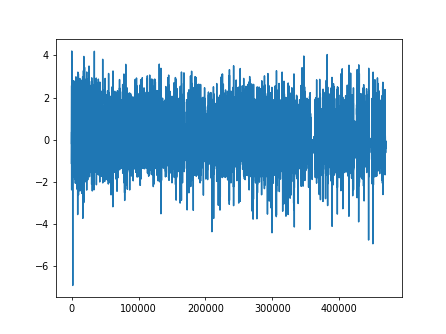

In [11]:
%matplotlib notebook
plt.figure()
# plt.plot(positions_new[30,0,:])
# plt.plot(displacements[30,0,:])
plt.plot(positions_new_sansOutliers[161,0,:])
# plt.plot(positions_tracked_outliers[300,0,:])
# plt.plot(positions_tracked_outliers_extended[300,0,:])
# plt.plot(displacements_sansOutliers[30,0,:])
# plt.plot(positions_new[30,0,:])
# plt.plot(positions_smoothed[30,0,:])
# np.squeeze(pointInds_toUse)

In [12]:
# Display video of displacement dot-grid after outlier removal

positions_toUse = positions_new_absolute_sansOutliers

# vidNums_toUse = range(numVids) ## note zero indexing!
vidNums_toUse = 0 ## note zero indexing!

if type(vidNums_toUse) == int:
    vidNums_toUse = np.array([vidNums_toUse])

dot_size = 2

printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over


## Define random colors for points in cloud
color_tuples =  list(np.arange(positions_toUse.shape[0]))
for ii in range(positions_toUse.shape[0]):
    color_tuples[ii] = (np.random.rand(1)[0]*255, np.random.rand(1)[0]*255 , np.random.rand(1)[0]*255)
#     color_tuples[ii] = (0,255,255)
        
        

## Main loop to pull out displacements in each video   
ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

fps = 0
tic_fps = time.time()
for iter , vidNum_iter in enumerate(vidNums_toUse):
    path_vid = path_vid_allFiles[vidNum_iter]
    video = cv2.VideoCapture(path_vid)
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    frameToSet = 0
    video.set(1,frameToSet)
    
    while True:
        
        ind_currentVid = np.int64(video.get(cv2.CAP_PROP_POS_FRAMES))
        if ind_currentVid >= numFrames:
            break
        ok, new_frame = video.read()

        for ii in range(positions_toUse.shape[0]):
            pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
            cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, color_tuples[ii], -1)
        
        cv2.putText(new_frame, f'frame #: {ind_currentVid}/{numFrames}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'vid #: {iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total}', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.imshow('test',new_frame)


        k = cv2.waitKey(1) & 0xff
        if k == 27 : break
            
        ind_concat = ind_concat+1

        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            

    cv2.destroyAllWindows()


NameError: name 'positions_new_absolute_sansOutliers' is not defined

In [19]:
vidNums_toUse[0]

3

In [16]:
cv2.destroyAllWindows()

<IPython.core.display.Javascript object>


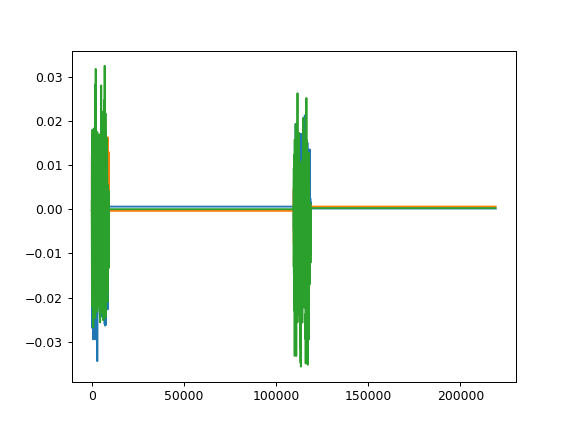

<IPython.core.display.Javascript object>


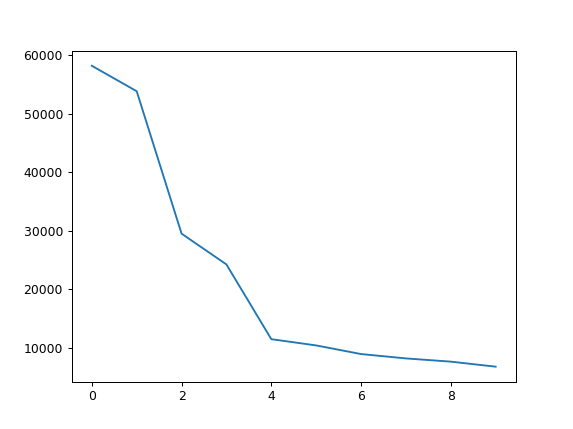

<IPython.core.display.Javascript object>


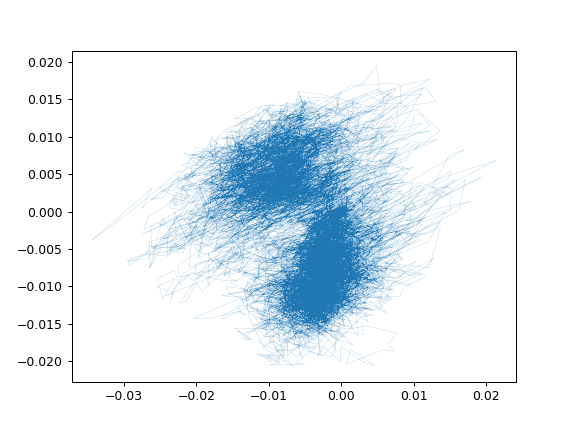

<IPython.core.display.Javascript object>


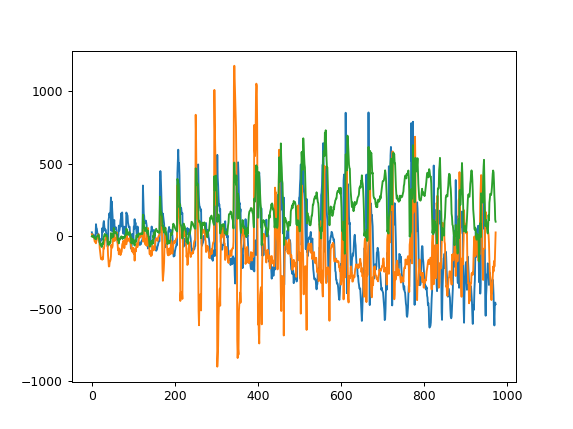

In [62]:
%matplotlib notebook
# input_dimRed = np.squeeze(positions_new_sansOutliers[:,1,:])
tmp_x = np.squeeze(positions_new_sansOutliers[:,0,:])
tmp_y = np.squeeze(positions_new_sansOutliers[:,1,:])
                   
input_dimRed_meanSub = np.concatenate((tmp_x - tmp_x.mean(1)[:,None] , tmp_y - tmp_y.mean(1)[:,None]) , axis=1 )
# input_dimRed_concat = np.concatenate( (np.squeeze(positions_new_sansOutliers[:,0,:]) , np.squeeze(positions_new_sansOutliers[:,1,:])) , axis=1)

# input_dimRed_meanSub = input_dimRed_concat - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed_concat , axis=1) , axis=1) , 1 , input_dimRed_concat.shape[1])
# input_dimRed_meanSub = input_dimRed_concat - input_dimRed_concat.mean(1)[:,None]

pca = sk.decomposition.PCA(n_components=10)
# pca = sk.decomposition.FastICA(n_components=10)
pca.fit(np.float32(input_dimRed_meanSub))
output_PCA = pca.components_.transpose()
scores_points = np.dot(input_dimRed_meanSub , output_PCA)

# plt.figure()
# plt.imshow(positions_tracked[:,])
plt.figure()
plt.plot(output_PCA[:,:3])
plt.figure()
plt.plot(pca.explained_variance_)
plt.figure()
plt.plot(output_PCA[:,0] , output_PCA[:,1]  , linewidth=.1)

plt.figure()
plt.plot(scores_points[:,:3])

In [19]:
# del input_dimRed_concat
del input_dimRed_meanSub
gc.collect()

328

In [66]:
# Display PCs

positions_toUse = positions_new_absolute_sansOutliers

# vidNums_toUse = range(numVids) ## note zero indexing!
vidNums_toUse = 0 ## note zero indexing!

if type(vidNums_toUse) == int:
    vidNums_toUse = np.array([vidNums_toUse])

dot_size = 3

printFPS_pref = 0
fps_counterPeriod = 10 ## number of frames to do a tic toc over

PC_toShow = 3
PC_toShow = PC_toShow-1

range_toUse = np.ceil(np.max(scores_points[:,PC_toShow]) - np.min(scores_points[:,PC_toShow])) + 1
offset_toUse = np.min(scores_points[:,PC_toShow])
scores_norm = scores_points[:,PC_toShow] - offset_toUse
scores_norm = (scores_norm / np.max(scores_norm)) *1000
cmap = matplotlib.cm.get_cmap('hot', 1000)


colormap_tuples =  list(np.arange(pointInds_toUse.shape[0]))
for ii in range(pointInds_toUse.shape[0]):
    colormap_tuples[ii] = list(np.flip((np.array(cmap(np.int64(scores_norm[ii]))) *255)[:3]))
        
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
save_pref = 0
if save_pref:
    out = cv2.VideoWriter('F:\RH_Local\Rich data\camera data\output.avi',fourcc, 120.0, (np.int64(vid_width * im_resize_factor), np.int64(vid_height * im_resize_factor)))
      

## Main loop to pull out displacements in each video   
ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

fps = 0
tic_fps = time.time()
for iter , vidNum_iter in enumerate(vidNums_toUse):
    path_vid = path_vid_allFiles[vidNum_iter]
    video = cv2.VideoCapture(path_vid)
    numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    frameToSet = 0
    video.set(1,frameToSet)
    
    while True:
        
        ind_currentVid = np.int64(video.get(cv2.CAP_PROP_POS_FRAMES))
        if ind_currentVid >= numFrames:
            break
        ok, new_frame = video.read()

        for ii in range(positions_toUse.shape[0]):
            pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
            cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, colormap_tuples[ii], -1)
        if save_pref:
            out.write(new_frame)
            
        cv2.putText(new_frame, f'frame #: {ind_currentVid}/{numFrames}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'vid #: {iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total}', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
        cv2.imshow('test',new_frame)


        k = cv2.waitKey(1) & 0xff
        if k == 27 : break
            
        ind_concat = ind_concat+1

        
        if ind_concat%fps_counterPeriod==0:
            elapsed = time.time() - tic_fps
            fps = fps_counterPeriod/elapsed
            if printFPS_pref:
                print(fps)
            tic_fps = time.time()
            

out.release()
video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [25]:
# out.release()
cv2.destroyAllWindows()


In [26]:
# %matplotlib notebook
# input_sgram = output_PCA[:,1]
# # input_sgram = ensemble.factors(5)[0][1][:,4]
# tmp = scipy.signal.savgol_filter(input_sgram , 101 , 3)
# input_sgram_processed = input_sgram - tmp
# plt.figure()
# # plt.plot(np.arange(input_sgram.shape[0])/Fs , np.vstack((input_sgram , input_sgram_processed, tmp)).transpose())
# plt.plot(np.arange(len(input_sgram))/Fs , np.vstack((input_sgram , input_sgram_processed, tmp)).transpose())
# # plt.plot(input_sgram)
# # np.vstack((input_sgram , input_sgram_processed)).transpose().shape

# # del scg
# # import scaleogram as scg

# scales = scg.periods2scales( np.arange(0.3, 10 , 0.1)**2 )
# # plt.figure()
# input_data = input_sgram
# scg.set_default_wavelet('cmor1-1.5')
# # importlib.reload(scg)

# ax = scg.cws(np.arange(input_data.shape[0])/Fs , input_data - np.mean(input_data) , scales=scales , cscale='log',
#             yaxis='frequency' , spectrum='power')


In [321]:
# spectrogram for every pixel

# import numba
# from numba import jit

# input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:]
input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:23000]


win_len = 0.5
win_overlap = win_len*0.9
nw = 3
ntapers = 1
fs = int(np.round(Fs))

f , t , Sxx = mtaper_specgram.mtaper_specgram(np.squeeze(input_sgram[0,0,:]) ,     
    nw=nw,
    ntapers = ntapers,
    win_len = win_len,
    win_overlap = win_overlap,
    fs=fs,
    clip=None,)

print(Sxx.shape)

Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , Sxx.shape[1] , 2)))

for ii in range(positions_new_sansOutliers.shape[0]):
    if ii%50 ==0:
        print(f'{ii} / {Sxx_allPixels.shape[0]}')
    for jj in range(2):
        tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])


        f , t , tmp = mtaper_specgram.mtaper_specgram(tmp_input_sgram ,     
            nw=nw,
            ntapers = ntapers,
            win_len = win_len,
            win_overlap = win_overlap,
            fs=fs,
            clip=None,)
# print(tmp.shape)

#         Sxx_allPixels[ii,:,:,jj] = scipy.stats.zscore(tmp_sgram , axis=1)
        tmp = scipy.stats.zscore(tmp , axis=1)
#         tmp = np.log2(tmp)
        tmp = tmp - np.min(tmp , axis=1)[:,None]
#         tmp = np.log2(tmp)
#         tmp = tmp - np.min(tmp , axis=1)[:,None]
#         tmp = scipy.stats.zscore(tmp , axis=1)

        Sxx_allPixels[ii,:,:,jj] = tmp
    

    
# @jit(nopython=False, parallel=True)
# def get_sgram(input_sgram , win_len , win_overlap , nw , ntapers , fs):
#     ''' practice
#     '''
#     f , t , Sxx = mtaper_specgram.mtaper_specgram(np.squeeze(input_sgram[0,0,:]) ,     
#         nw=nw,
#         ntapers = ntapers,
#         win_len = win_len,
#         win_overlap = win_overlap,
#         fs=fs,
#         clip=None,)


#     Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , Sxx.shape[1] , 2)))
#     for ii in numba.prange(positions_new_sansOutliers.shape[0]):
# #         if ii%50 ==0:
# #             print(f'{ii} / {Sxx_allPixels.shape[0]}')
#         for jj in numba.prange(2):
#             tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])


#             tmp = mtaper_specgram.mtaper_specgram(tmp_input_sgram ,     
#                 nw=nw,
#                 ntapers = ntapers,
#                 win_len = win_len,
#                 win_overlap = win_overlap,
#                 fs=fs,
#                 clip=None,)

#             tmp = scipy.stats.zscore(tmp , axis=1)
#             tmp = tmp - np.min(tmp , axis=1)[:,None]
#             Sxx_allPixels[ii,:,:,jj] = tmp
    
#     return f , t , Sxx_allPixels

# f , t , Sxx_allPixels = get_sgram(input_sgram , win_len , win_overlap , nw , ntapers , fs)


(31, 3824)
0 / 162
50 / 162
100 / 162
150 / 162


In [322]:
print(Sxx_allPixels.shape)
print(Sxx_allPixels.shape[0]*Sxx_allPixels.shape[1]*Sxx_allPixels.shape[2]*Sxx_allPixels.shape[3])
print(Sxx_allPixels.dtype)
sys.getsizeof(Sxx_allPixels) / 1000000000

(162, 31, 3824, 2)
38408256
float32


0.153633168

In [24]:
save_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
save_name = f'Sxx_allPixels'
save_fullPath = f'{save_dir}/{save_name}.npy'

np.save(save_fullPath , Sxx_allPixels)

In [25]:
gc.collect()

60

In [13]:
# wavelet scalogram for every pixel
import math
import multiprocessing
from multiprocessing import Pool

input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[:,:,:]


tmp = np.squeeze(input_sgram[0,0,:])
t = np.arange(len(tmp)) / Fs
dt = t[1] - t[0]
wavelet = 'cmor3-1.0'
# wavelet = 'shan30-10.0'
scales_log_base = 10
scales_start = 2 # in scales relative to 1/dt (half of nyquist)
scales_stop = 300
scales_num = 50 # number of scales to use
decimation_factor = 10

scales = np.logspace(math.log(scales_start,scales_log_base), math.log(scales_stop,scales_log_base), num=scales_num, base=scales_log_base)


[Sxx, freqs_Sxx] = pywt.cwt(np.squeeze(input_sgram[0,0,:]), scales, wavelet, dt)


# print(Sxx.shape)


# for ii in range(positions_new_sansOutliers.shape[0]):
def makeSxx(ii):
#     if ii%5 ==0:
#         print(f'{ii} / {Sxx_allPixels.shape[0]}')
    for jj in range(2):
        tmp_input_sgram = np.squeeze(input_sgram[ii,jj,:])

        [tmp, freqs_Sxx] = pywt.cwt(tmp_input_sgram, scales, wavelet, dt)
        tmp = (abs(tmp)) ** 2

#         tmp = scipy.stats.zscore(tmp , axis=1)
        tmp = tmp / np.std(tmp , axis=1)[:,None]
#         tmp = scipy.signal.decimate(tmp, decimation_factor, ftype='fir', axis=1, zero_phase=True)
        tmp = tmp[:,np.uint32(np.arange(0,tmp.shape[1], decimation_factor))]
#         tmp = tmp - np.min(tmp , axis=1)[:,None]

        if jj==1:
            Sxx = np.concatenate((tmp1[:,:,None] , tmp[:,:,None]) , axis=2)
        tmp1 = tmp
        print(ii)


#         Sxx_allPixels[ii,:,:,jj] = tmp
    return Sxx
p = Pool(multiprocessing.cpu_count())
Sxx_allPixels_weird = p.map(makeSxx , list(np.arange(positions_new_sansOutliers.shape[0])))

p.close()
p.terminate()
p.join()

434
372
496
1023
992
1054
682
465
62
527
868930248

961

2175581085
775


589806

620651
155

341713
744
279403

31

124
186837

0
93
899
310
434
1023
372
682
992
62
1054589

465
155
651248

86831496


961341
279
217

77593
1085

806713
186
899403

744558


0930
620

837124

527
310
435
1024
683
993
63
590373

1055
466
249
156
218
497
280
900962

869
32
559
931714

838
807776621


342652

745
528
108694187


404125311
1


435
1024
683
590
1055
373
993
63
156466

218
900
32
249
280869

962497

621
714
559
1086
776
838
94
745
652
931
404
807
342
311
1
528
187
125
436
1025
684
1056
591
64
157
994
374
219467

901
281
963
33
870
250
622
715
560
1087
777
95
405498

746
343
839
932
312
529
653
808126

2
188
436
1025
684
994
157
1056
591
64
901
374
219
467
281
963
870
33
622
1087
250
777
560
498
715
746
405
126
808
312
95932

343
2
188
839
653
529
437
1026
685
158
99565

592
902
1057
220
375
282
468
871
964
34
623
778
1088
251
499
561
96
747
406
716
3
654344

127809

840
933
189
313
530
437
68

121
648
214
28
710
865
307
183
493
1082
338
927
586
1051
1020
989
400
741
524
276
91
772
803
679
617
1113
152
834
958
60
555
369
463
245
431
214
649
121
897
28
865
184
494
711
308
338
1083
928
1052
587
1021
990
401
804
277
74291

524
618
1114
772
152
679
959
835
60
556
370
463
215
246
431
866
649
122
29
897
184
494
711
1083
308
339
928
1052
587
1021
990
401
804
277
742
92
773
1114
618
153
959
525
680
464
61
835
556
370
215
246
432
866
122650

29
185
898
495
1084
339929

712
309
588
1053
1022
402
991
278
805
92
743
619
1115
773
960
153
61
680
525
464
371836

557
216
432
867
247
30
650
123
185
898
495
1084
929
340
309
588
712
1053
1022
743
402
991
805
278
557
960
371
774
619
1115
154
433
86730836


681
216
123
526
247
1116
340
1147
1178
774
433
154
1209
1116
526
681
1240
1271
1302
1147
1178
1333
1364
1209
1117
1395
1240
1271
1426
1302
1457
1148
1179
1333
1488
1364
1210
1519
1117
1395
1241
1550
1272
1426
1581
1303
1612
1148
1334
1457
1488
1179
1210
1396
1118
1643
1519
1550
1241
1736
1581


1601
1694
1323
1416
2220
1570
1787
2003
2127
1509
1168
1756
1478
2065
1973
1447
1818
1633
1540
2096
1385
1880
1663
1138
1293
1231
1262
1849
1942
2189
1911
1200
1355
2158
1324
2034
1602
1694
1725
2220
1417
1788
1510
1571
2004
2128
1169
1478
1973
1757
2066
1448
1541
1633
1818
2097
1386
1880
1664
1139
1293
1231
1849
1942
1262
1912
1602
2189
1201
1355
2159
1695
1324
1726
2035
2221
1417
1788
1510
1571
2128
2004
1169
1479
2066
1757
1974
1448
1634
1541
2097
1819
1386
1664
1881
1139
1850
12321294

1943
1263
1201
1912
1356
2190
1695
1603
1325
1726
2159
2035
2221
1511
1789
1418
1572
2129
2005
1170
1479
1974
2067
1449
1758
1634
1387
1819
1542
2098
1665
1232
1881
1294
1140
1943
1850
1202
1263
1696
1325
1913
2190
13561603

1727
1418
2036
2160
17892222

1511
2129
1572
2005
1170
1480
1449
1975
1635
2067
1758
1542
1387
1820
2098
1665
1202
1295
1882
1233
1944
1140
1851
1264
1696
1326
1913
1357
2191
20361604

2130
1727
2222
1419
1512
2160
1790
2006
1573
1480
1759
1171
1975
1388
1450
1635
2068
1543
1820


2616
2246
2740
3111
3173
2864
2369
3204
3018
2709
2987
2678
2895
3235
2493
3080
2400
2431
2277
3297
2339
2957
2308
2802
3327
2555
2648
3142
32663050

2586
2462
2833
2926
2524
2617
2246
2771
2740
2864
3173
3111
2370
3204
2679
2710
2895
3019
2988
3235
2494
2401
2432
3081
2277
2339
3297
2957
2803
2556
2308
3328
2648
3050
3266
2834
2463
2587
3143
2525
2617
2927
2772
2247
2865
2741
3174
3112
2370
3205
3019
2710
2679
2988
3236
2494
2896
2401
2432
3081
2340
2278
3298
2958
2803
2556
3267
3328
2927
2834
2649
2309
24632772

2525
3143
3051
2587
2618
2247
2865
3112
2741
3174
3205
3020
2371
2711
2680
3236
2495
2989
2896
2433
2402
3082
2340
2278
3298
2958
2804
2557
2588
2928
2835
3267
3329
2309
2248
3051
24642526

2649
3144
2773
2866
3113
2618
3175
2742
2680
2711
3020
3206
2371
2495
3237
2989
2433
2897
2402
3082
2341
2279
3299
2959
2804
2310
2248
2928
2588
2835
2464
2526
3268
2557
3329
3144
2650
3052
3113
2773
2866
2742
2619
3175
3021
2712
3206
2681
2496
2372
2990
3237
2897
2434
2403
3083
2341
2279


3632
4064
3385
4250
3694
3879
4281
3972
3756
4157
3601
3725
3817
3416
3663
4312
3355
3848
4034
3509
4065
4003
4219
3539
3910
3571
4096
3941
4127
3787
3478
3447
3880
4188
3632
3385
3694
4250
4281
3972
3756
4158
3725
3818
3602
3664
3355
3416
3509
3849
4312
3880
4034
3540
3911
4003
4065
4220
4127
3942
3478
4189
3571
3787
4096
3447
3633
4251
3695
3386
3757
4282
3973
3602
4158
3726
3664
3818
3356
3417
3510
4035
4004
3849
4313
3881
3633
4097
3540
3911
4220
4066
3572
4128
3942
3479
3448
4189
4251
3695
3788
3757
3386
4282
3973
3603
4159
3726
3819
3417
3665
3510
3356
4190
4035
3850
3788
4313
3912
4004
3634
3881
3541
3943
4221
4097
3572
4128
4066
3448
3696
3479
4252
3758
3387
4283
3974
3603
4159
3727
3511
3819
4190
3850
4005
3665
3789
3418
3357
3541
4036
4098
4314
3943
3912
4129
3882
3758
4221
4067
3634
3573
3387
3696
3480
4252
3449
4283
3974
3604
4160
3727
3511
3418
4191
3820
4005
3851
3944
3666
3789
3357
4098
3882
3913
3542
4036
4314
4129
3759
4067
3635
4222
3388
3697
3573
4253
34803449

4284


3998
3936
4028
4307
4276
4121
4245
4184
4215
4059
3874
4153
4091
4029
4307
4276
4122
4246
4215
4184
4060
4091
4029
4308
4277
4122
4246
4060
4308
4277


In [15]:
Sxx_allPixels = np.single(np.zeros((input_sgram.shape[0] , Sxx.shape[0] , np.uint32(np.ceil(Sxx.shape[1]/decimation_factor)) , 2)))
for ii in range(len(Sxx_allPixels_weird)):
    Sxx_allPixels[ii,:,:,:] = Sxx_allPixels_weird[ii]

In [17]:
sys.getsizeof(Sxx_allPixels)/1000000000

81.400012944

In [89]:
p.close()
p.terminate()
p.join()


In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(Sxx_allPixels[100,:,:,0]  , aspect='auto' , cmap='hot' , origin='lower')


In [ ]:
print(Sxx_allPixels.shape)
print(Sxx_allPixels.shape[0]*Sxx_allPixels.shape[1]*Sxx_allPixels.shape[2]*Sxx_allPixels.shape[3])
print(Sxx_allPixels.dtype)
sys.getsizeof(Sxx_allPixels) / 1000000000

In [18]:
# im_toShow = np.squeeze(input_sgram[161,0,:])
# t = np.arange(len(im_toShow)) / Fs
# dt = t[1] - t[0]
# wavelet = 'cmor3-1.0'

# scales_log_base = 10
# scales_start = 2 # in scales relative to 1/dt (half of nyquist)
# scales_stop = 700
# scales_num = 50 # number of scales to use

# scales = np.logspace(math.log(scales_start,scales_log_base), math.log(scales_stop,scales_log_base), num=scales_num, base=scales_log_base)

# [cfs, frequencies] = pywt.cwt(im_toShow, scales, wavelet, dt)
# power = (abs(cfs)) ** 2

settings_wavelet =	{
    "t": t,
    "dt": dt,
    "wavelet": 'cmor3-1.0',
    'scales_log_base': scales_log_base,
    'scales_start': scales_start,
    'scales_stop': scales_stop,
    'scales_num': scales_num,
    'scales': scales,
    'decimation_factor': decimation_factor }

In [19]:
save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run2'
save_name = f'settings_wavelet'
save_fullPath = f'{save_dir}/{save_name}.npy'

np.save(save_fullPath , settings_wavelet)


save_dir = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run2'
save_name = f'Sxx_allPixels'
save_fullPath = f'{save_dir}/{save_name}.npy'

np.save(save_fullPath , Sxx_allPixels)

In [22]:
load_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
load_name = f'Sxx_allPixels'
load_fullPath = f'{load_dir}/{load_name}.npy'

Sxx_allPixels = np.load(load_fullPath)


In [23]:
load_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
load_name = f'freqXaxis'
load_fullPath = f'{load_dir}/{load_name}.npy'

freqXaxis = np.load(load_fullPath)


In [26]:
wavlist = pywt.wavelist(kind='continuous')
print(wavlist)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


# scales = np.arange(1, 128)
# scales = np.arange(2, 128**(1/2) , 0.1)**(2)
# scales = np.logspace(math.log(2,10), 3, num=50, base=10.0)
# frequencies = pywt.scale2frequency('cmor1.5-1.0', [1, 2, 3, 4]) / dt
scales.shape
scales
frequencies

print(im_toShow.shape)
print(t.shape)
print(frequencies.shape)
print(power.shape)

<IPython.core.display.Javascript object>


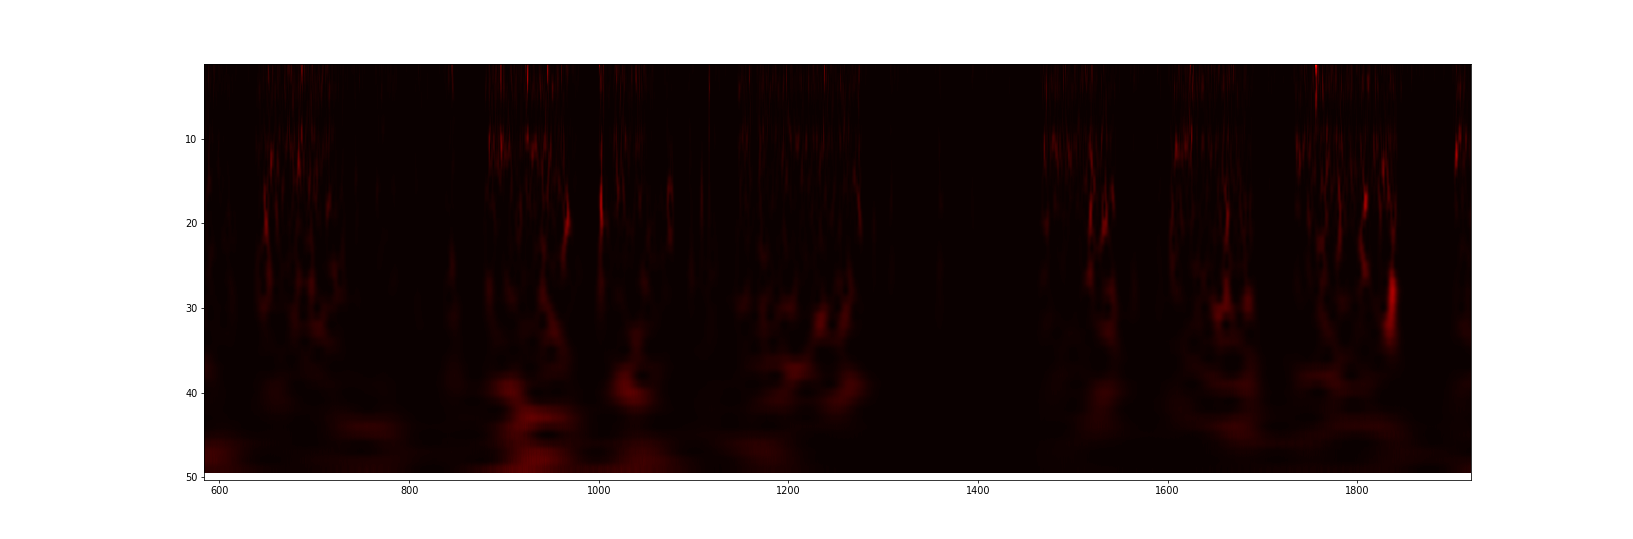

In [23]:
fig = plt.figure()
# plt.pcolor(t , frequencies , power , shading='auto')
# ax = fig.add_subplot()
# plt.imshow(scipy.signal.decimate(np.flipud(scipy.stats.zscore(power , axis=1)) , 1 , ftype='iir', axis=1, zero_phase=True)  , aspect='auto' , cmap='hot' , origin='lower')
plt.imshow(Sxx_allPixels[200,:,:,0] , aspect='auto' , cmap='hot')
# ax.set_yscale('log')
# plt.ylim([0,10**(3.11)])

In [24]:
Sxx_allPixels.shape

(4332, 50, 46976, 2)

(31, 3824)


<IPython.core.display.Javascript object>


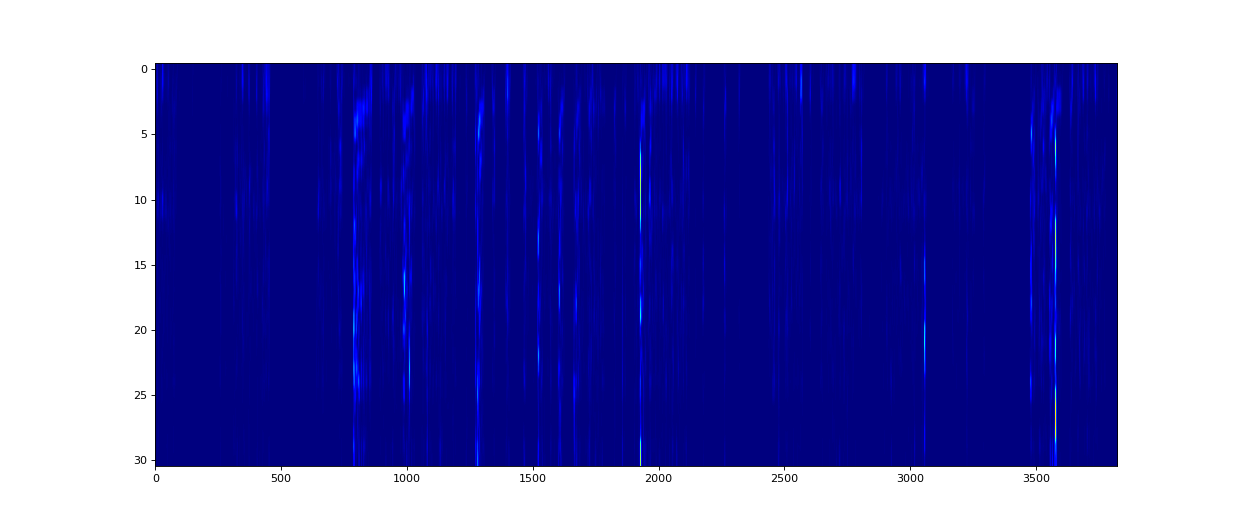

In [25]:
im_toShow = np.squeeze(Sxx_allPixels[161,:,:,0])
print(im_toShow.shape)
plt.figure()
plt.imshow(im_toShow , aspect='auto' , cmap='jet')

# plt.figure()
# plt.plot(im_toShow.transpose()[:,:5])

In [34]:
# input_sgram = np.single(np.squeeze(positions_new_sansOutliers))[0,0,:30000]

# win_len = 0.3
# win_overlap = win_len*0.9

# f , t , Sxx = mtaper_specgram.mtaper_specgram(input_sgram ,     
#     nw=3,
#     ntapers = 1,
#     win_len = win_len,
#     win_overlap = win_overlap,
#     fs=int(120),
#     clip=None,)

# extent = [t.min() , t.max() , f.max() , f.min()]
# plt.figure()
# plt.imshow(scipy.stats.zscore(Sxx , axis=1) , aspect='auto' , extent=extent , vmin=0 , vmax=8)
# Sxx.shape
# # input_sgram.shape

In [40]:
# input_dimRed_x = np.squeeze(positions_sansOutliers_smoothed[:,0,:])
# input_dimRed_meanSub_x = input_dimRed - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed , axis=1) , axis=1) , 1 , input_dimRed.shape[1])
# input_dimRed_y = np.squeeze(positions_sansOutliers_smoothed[:,1,:])
# input_dimRed_meanSub_y = input_dimRed - np.matlib.repmat( np.expand_dims(np.mean(input_dimRed , axis=1) , axis=1) , 1 , input_dimRed.shape[1])


# data = np.dstack((input_dimRed_x , input_dimRed_y))# ... specify a numpy array holding the tensor you wish to fit
data = Sxx_allPixels
print(f'shape of data: {data.shape}')

# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(data, ranks=range(5, 6), replicates=1)

Fitting rank-5 models:   0%|          | 0/1 [00:00<?, ?it/s]

shape of data: (671, 31, 17824, 2)


/home/rich/miniconda3/envs/torch_env/lib/python3.8/site-packages/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/home/rich/miniconda3/envs/torch_env/lib/python3.8/site-packages/numba/core/typing/npydecl.py:930: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
                                                                     

Rank-5 models:  min obj, 0.67;  max obj, 0.67;  time to fit, 671.5s


In [ ]:
ensemble_normGram = copy.deepcopy(ensemble)
# ensemble_lessOverlap = copy.deepcopy(ensemble)

<IPython.core.display.Javascript object>


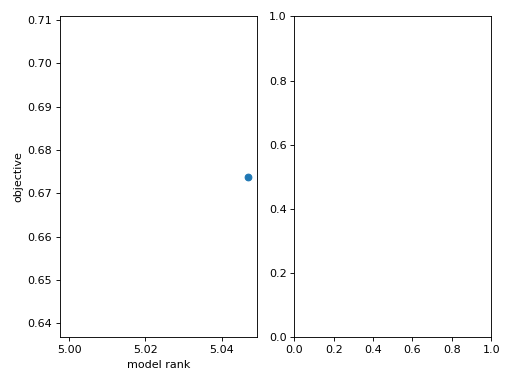

In [41]:
ensemble_toUse = ensemble

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble_toUse, ax=axes[0])   # plot reconstruction error as a function of num components.
# tt.plot_similarity(ensemble_toUse, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

In [31]:
modelRank_toUse = 5
modelIter_toUse = 0

ensemble_toUse = ensemble

plt.figure()
# plt.plot(np.arange(ensemble_toUse.factors(4)[0][2].shape[0])/Fs , ensemble_toUse.factors(4)[0][2])
factors_temporal = scipy.stats.zscore(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2][:,:] , axis=0)
plt.plot(factors_temporal)
plt.figure()
plt.plot(f , ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][1])
plt.figure()
plt.plot(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][3])
plt.figure()
plt.plot(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][0])

plt.figure()
plt.imshow(np.corrcoef(ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2].transpose()))

input_dimRed = ensemble_toUse.factors(modelRank_toUse)[modelIter_toUse][2]
# input_dimRed_meanSub = 
pca = sk.decomposition.PCA(n_components=modelRank_toUse-2)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(input_dimRed.transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

plt.figure()
plt.plot(output_PCA)

NameError: name 'ensemble' is not defined

In [11]:
# use tensorly
import tensorly as tl
import tensorly.decomposition
import tensorly.random
# import torch
# import torch.cuda

print(torch.cuda.current_device())

random_state = 1234
rng = tensorly.random.check_random_state(random_state)

tl.set_backend('pytorch')
# device = 'cuda:0'
device = 'cpu'

0


In [12]:
Sxx_allPixels_tensor = tl.tensor(Sxx_allPixels[:,:,:,:], dtype=tl.float32, device=device, requires_grad=False)
# Sxx_allPixels_tensor = tl.tensor(Sxx_allPixels[:,:,:,:], dtype=tl.float32)

del Sxx_allPixels
del positions_new_sansOutliers
gc.collect()

In [13]:
rank = 8

# weights, factors = tensorly.decomposition.non_negative_parafac(tl.tensor(Sxx_allPixels[:,:,:,:], dtype=tl.float32, device=device, requires_grad=True)
weights2, factors2 = tensorly.decomposition.non_negative_parafac(Sxx_allPixels_tensor, init='random', tol=2e-04, n_iter_max=20, rank=rank, verbose=True)
# weights2, factors2 = tensorly.decomposition.parafac(Sxx_allPixels_tensor, init='random', tol=1e-05, n_iter_max=1000, rank=rank, verbose=True)

reconstruction error=0.9312875866889954
iteration 1, reconstraction error: 0.9252294898033142, decrease = 0.006058096885681152
iteration 2, reconstraction error: 0.9211663007736206, decrease = 0.0040631890296936035
iteration 3, reconstraction error: 0.9161821007728577, decrease = 0.0049842000007629395
iteration 4, reconstraction error: 0.9107862710952759, decrease = 0.005395829677581787
iteration 5, reconstraction error: 0.9060158729553223, decrease = 0.004770398139953613
iteration 6, reconstraction error: 0.9020410180091858, decrease = 0.003974854946136475
iteration 7, reconstraction error: 0.8985094428062439, decrease = 0.0035315752029418945
iteration 8, reconstraction error: 0.8951499462127686, decrease = 0.003359496593475342
iteration 9, reconstraction error: 0.8919047117233276, decrease = 0.003245234489440918
iteration 10, reconstraction error: 0.8888749480247498, decrease = 0.003029763698577881
iteration 11, reconstraction error: 0.8861674666404724, decrease = 0.00270748138427734

In [19]:
Fs = 120

<IPython.core.display.Javascript object>


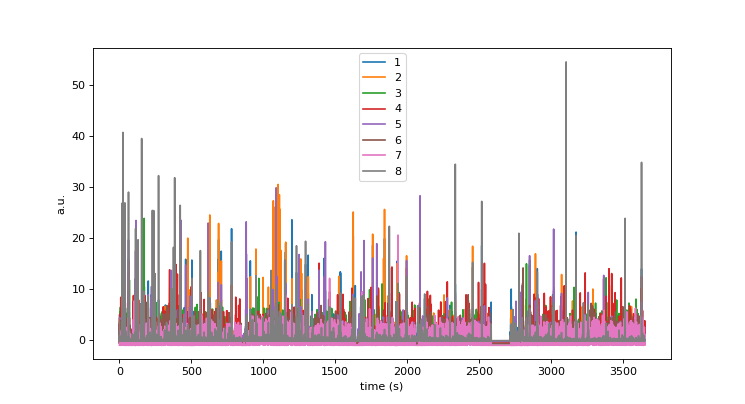

<IPython.core.display.Javascript object>


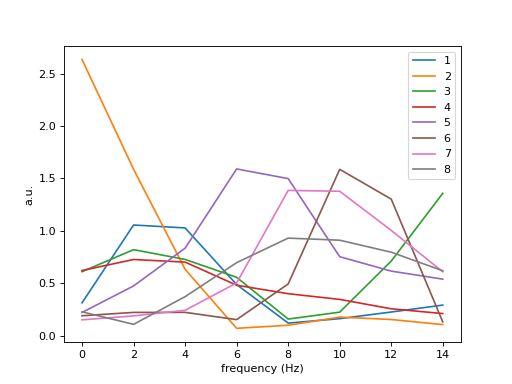

<IPython.core.display.Javascript object>


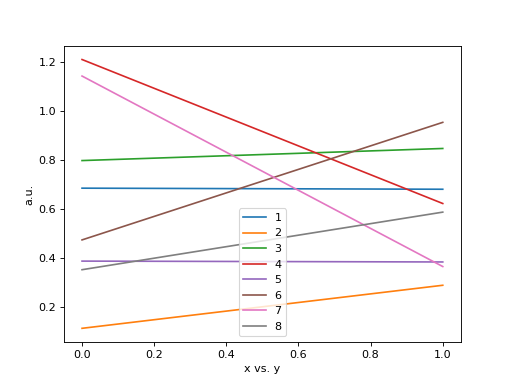

<IPython.core.display.Javascript object>


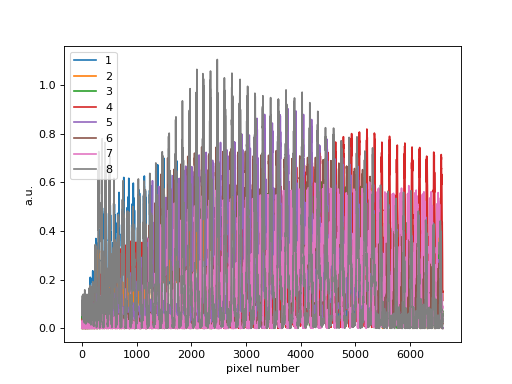

<IPython.core.display.Javascript object>


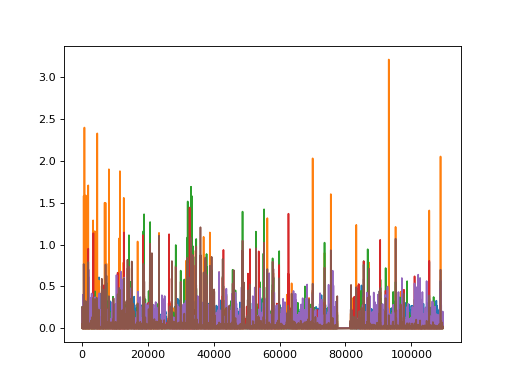

In [27]:
%matplotlib notebook

ensemble_toUse = factors2
modelRank = ensemble_toUse[0].shape[1]

plt.figure()
# plt.plot(np.arange(ensemble_toUse.factors(4)[0][2].shape[0])/Fs , ensemble_toUse.factors(4)[0][2])
factors_temporal = scipy.stats.zscore(ensemble_toUse[2][:,:] , axis=0)
plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('time (s)')
plt.ylabel('a.u.')

plt.figure()
# plt.plot(freqs_Sxx , (ensemble_toUse[1][:,:]))
plt.plot(freqXaxis , (ensemble_toUse[1][:,:]))
# plt.plot(f , (ensemble_toUse[1][:,:]))
# plt.plot((ensemble_toUse[1][:,:]))
plt.legend(np.arange(modelRank)+1)
plt.xlabel('frequency (Hz)')
plt.ylabel('a.u.')

plt.figure()
plt.plot(ensemble_toUse[3][:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('x vs. y')
plt.ylabel('a.u.')

plt.figure()
plt.plot(ensemble_toUse[0][:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('pixel number')
plt.ylabel('a.u.')


# plt.figure()
# plt.imshow(np.single(np.corrcoef(ensemble_toUse[2][:,:])))

input_dimRed = ensemble_toUse[2][:,:]
# input_dimRed_meanSub = 
pca = sk.decomposition.NMF(n_components=modelRank-2)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

plt.figure()
plt.plot(output_PCA)

In [15]:
## make numpy version of tensorly output

factors_toUse = factors2

save_pref = 1
save_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
save_path_factors = f'{save_dir}/factors_np2.npy'
save_path_freqXaxis = f'{save_dir}/freqXaxis2.npy'

numFactorDims = len(factors_toUse)
# print(numFactorDims)

factors_np = []
for ii in range(numFactorDims):
    factors_np.append(np.array(factors_toUse[ii]))

if save_pref:
    np.save(save_path_factors , factors_np)
    print(f'Saved: {save_path_factors}')
    np.save(save_path_freqXaxis , f)
    print(f'Saved: {save_path_freqXaxis}')
    

Saved: /media/rich/bigSSD RH/tmp_download/run_2/factors_np2.npy


NameError: name 'f' is not defined

In [24]:
load_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
load_path_factors = f'{load_dir}/factors_np2.npy'
load_path_freqXaxis = f'{load_dir}/freqXaxis.npy'

factors2 = np.load(load_path_factors , allow_pickle=True)
freqXaxis = np.load(load_path_freqXaxis)

In [52]:
# Display video of factors
factors_toShow = np.arange(8)  # zero-indexed
# factors_toShow = [3]  # zero-indexed

for factor_iter in factors_toShow:

    # vidNums_toUse = range(numVids) ## note zero indexing!
    vidNums_toUse = 0 ## note zero indexing!

    if type(vidNums_toUse) == int:
        vidNums_toUse = np.array([vidNums_toUse])

    dot_size = 1

    printFPS_pref = 0
    fps_counterPeriod = 10 ## number of frames to do a tic toc over

    modelRank_toUse = 5
    factor_toShow = factor_iter+1
    save_pref= 0

    # save_dir = "F:\\RH_Local\\Rich data\\camera data"
    save_dir = f'/media/rich/bigSSD RH/tmp_download/run_2'
    save_fileName = f'factor {factor_toShow}'
    # save_pathFull = f'{save_dir}\\{save_fileName}.avi'
    save_pathFull = f'{save_dir}/{save_fileName}.avi'

    # ensemble_toUse = ensemble
    ensemble_toUse = factors2
    positions_toUse = positions_new_absolute_sansOutliers

    factor_toShow = factor_toShow-1
    # input_scores = ensemble_toUse.factors(modelRank_toUse)[0][0]
    input_scores = np.single(ensemble_toUse[0])

    range_toUse = np.ceil(np.max(input_scores[:,factor_toShow]) - np.min(input_scores[:,factor_toShow])) + 1
    offset_toUse = np.min(input_scores[:,factor_toShow])
    scores_norm = input_scores[:,factor_toShow] - offset_toUse
    scores_norm = (scores_norm / np.max(scores_norm)) *1000
    cmap = matplotlib.cm.get_cmap('hot', 1000)
    # cmap_viridis(np.arange(range_toUse))

    colormap_tuples =  list(np.arange(positions_toUse.shape[0]))
    for ii in range(positions_toUse.shape[0]):
        colormap_tuples[ii] = list(np.flip((np.array(cmap(np.int64(scores_norm[ii]))) *255)[:3]))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    if save_pref:
        print(f'saving to file {save_pathFull}')
        out = cv2.VideoWriter(save_pathFull, fourcc, Fs, (np.int64(vid_width), np.int64(vid_height)))


    ## Main loop to pull out displacements in each video   
    ind_concat = int(np.hstack([0 , np.cumsum(numFrames_allFiles)])[vidNums_toUse[0]])

    fps = 0
    tic_fps = time.time()
    for iter , vidNum_iter in enumerate(vidNums_toUse):
        path_vid = path_vid_allFiles[vidNum_iter]
        video = cv2.VideoCapture(path_vid)
    #     numFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        numFrames = 600

        frameToSet = 0
        video.set(1,frameToSet)

        while True:

            ind_currentVid = np.int64(video.get(cv2.CAP_PROP_POS_FRAMES))
            if ind_currentVid >= numFrames:
                break
            ok, new_frame = video.read()

            for ii in range(positions_toUse.shape[0]):
                pointInds_tracked_tuple = tuple(np.int64(np.squeeze(positions_toUse[ii,:,ind_concat])))
                cv2.circle(new_frame,pointInds_tracked_tuple, dot_size, colormap_tuples[ii], -1)
            if save_pref:
                out.write(new_frame)

#             Sxx_frameNum = round( ind_currentVid / (positions_toUse.shape[2] / Sxx_allPixels.shape[2]) ,1)
            cv2.putText(new_frame, f'frame #: {ind_currentVid}/{numFrames}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
#             cv2.putText(new_frame, f'frame #: {Sxx_frameNum}', org=(10,20), fontFace=1, fontScale=1, color=(255,255,255), thickness=2)
            cv2.putText(new_frame, f'vid #: {iter+1}/{len(vidNums_toUse)}', org=(10,40), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'total frame #: {ind_concat+1}/{numFrames_total}', org=(10,60), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'fps: {np.uint32(fps)}', org=(10,80), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.putText(new_frame, f'factor num: {factor_iter+1} / {np.max(factors_toShow)+1}', org=(10,100), fontFace=1, fontScale=1, color=(255,255,255), thickness=1)
            cv2.imshow('test',new_frame)


            k = cv2.waitKey(1) & 0xff
            if k == 27 : break

            ind_concat = ind_concat+1


            if ind_concat%fps_counterPeriod==0:
                elapsed = time.time() - tic_fps
                fps = fps_counterPeriod/elapsed
                if printFPS_pref:
                    print(fps)
                tic_fps = time.time()


out.release()
video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [14]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca',
                     random_state=0, perplexity=500)
X_tsne = tsne.fit_transform(factors_temporal)
print("Finished computing t-SNE embedding")


Computing t-SNE embedding
Finished computing t-SNE embedding


<IPython.core.display.Javascript object>


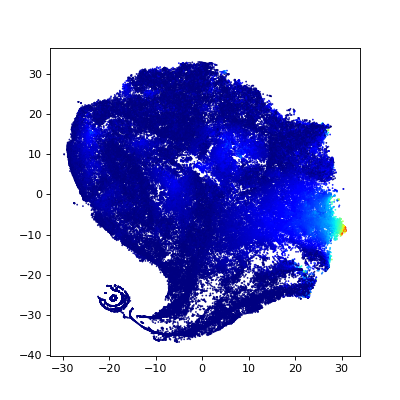

In [49]:
factor_toCMap = 4  # 1 indexed

plt.figure(figsize=(5,5))
# plt.plot(X_tsne[:,0] , X_tsne[:,1] , linewidth=0.03)
# plt.scatter(X_tsne[:,0] , X_tsne[:,1], 'r.' , markersize=0.6)
plt.scatter(X_tsne[:,0] , X_tsne[:,1] , s=0.3, c=factors_temporal[:,factor_toCMap-1] , cmap='jet')


In [47]:
cv2.destroyAllWindows()

# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = 8
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()


<IPython.core.display.Javascript object>


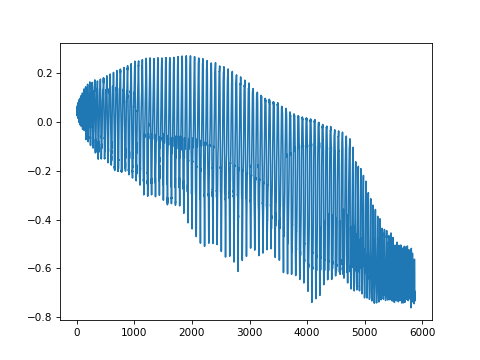

<IPython.core.display.Javascript object>


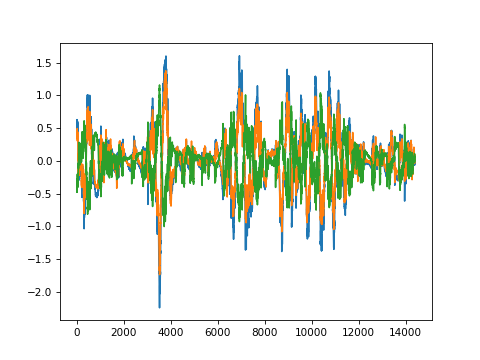

In [85]:
plt.figure()
plt.plot(ensemble.factors(3)[0][0][:,1])
# ensemble.factors(1)[0][0].shape

plt.figure()
plt.plot(ensemble.factors(9)[0][1][:,:3])

video.set(1,88876)
video.get(cv2.CAP_PROP_POS_FRAMES)

tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
tracker_typeToUse = tracker_types[0]


if int(minor_ver) < 3:
    tracker = cv2.Tracker_create(tracker_typeToUse)
else:
    if tracker_typeToUse == 'BOOSTING':
        tracker = cv2.TrackerBoosting_create()
    if tracker_typeToUse == 'MIL':
        tracker = cv2.TrackerMIL_create()
    if tracker_typeToUse == 'KCF':
        tracker = cv2.TrackerKCF_create()
    if tracker_typeToUse == 'TLD':
        tracker = cv2.TrackerTLD_create()
    if tracker_typeToUse == 'MEDIANFLOW':
        tracker = cv2.TrackerMedianFlow_create()
    if tracker_typeToUse == 'GOTURN':
        tracker = cv2.TrackerGOTURN_create()
    if tracker_typeToUse == 'MOSSE':
        tracker = cv2.TrackerMOSSE_create()
    if tracker_typeToUse == "CSRT":
        tracker = cv2.TrackerCSRT_create()

frameToSet = 0
video.set(1,frameToSet)
ok, frame = video.read()
cv2.imshow('Select ROI' , frame)
bbox = cv2.selectROI(frame,False)
print(bbox)
ok = tracker.init(frame,bbox)
print(ok)
cv2.destroyAllWindows()

video.set(2,0); # first input is the property number, 2 is the frame ID to set. second input is frame ID
while True:
    # Read a new frame
    ok, frame = video.read()
    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);

    # Draw bounding box
    if ok:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255,0,0), 2, 1)
    else :
        # Tracking failure
        cv2.putText(frame, "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

    # Display tracker type on frame
    cv2.putText(frame, tracker_typeToUse + " Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2);

    # Display FPS on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);

    # Display result
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    k = cv2.waitKey(1) & 0xff
    if k == 27 : break
cv2.destroyAllWindows()

In [47]:
cv2.destroyAllWindows()

In [68]:
plt.close('all')